In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip "/content/drive/MyDrive/VGGFace/fer2013_ss.zip" -d "/content/fer"

Görüntülenen çıkış son 5000 satıra kısaltıldı.
  inflating: /content/fer/Training/8736.jpg  
  inflating: /content/fer/Training/8737.jpg  
  inflating: /content/fer/Training/8738.jpg  
  inflating: /content/fer/Training/8739.jpg  
  inflating: /content/fer/Training/874.jpg  
  inflating: /content/fer/Training/8740.jpg  
  inflating: /content/fer/Training/8741.jpg  
  inflating: /content/fer/Training/8742.jpg  
  inflating: /content/fer/Training/8743.jpg  
  inflating: /content/fer/Training/8744.jpg  
  inflating: /content/fer/Training/8745.jpg  
  inflating: /content/fer/Training/8746.jpg  
  inflating: /content/fer/Training/8747.jpg  
  inflating: /content/fer/Training/8748.jpg  
  inflating: /content/fer/Training/8749.jpg  
  inflating: /content/fer/Training/875.jpg  
  inflating: /content/fer/Training/8750.jpg  
  inflating: /content/fer/Training/8751.jpg  
  inflating: /content/fer/Training/8752.jpg  
  inflating: /content/fer/Training/8753.jpg  
  inflating: /content/fer/Training/

In [ ]:
!pip install keras_vggface

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install keras_applications

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 3.4 MB/s 


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, Input, Dense, Flatten, MaxPool2D, BatchNormalization, Dropout
from tensorflow.keras import Model, models
from tensorflow.keras.optimizers import SGD
from keras_vggface.vggface import VGGFace
from keras.callbacks import ModelCheckpoint

from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
df = pd.read_csv("/content/fer/fer2013.csv")
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


In [ ]:
df["Usage"].value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

In [ ]:
df["emotion"].value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

In [ ]:
def append_ext(name):
    return name+".jpg"

In [ ]:
y_train = pd.read_csv('/content/fer/labels/traininglabel.csv',dtype=str)
y_val = pd.read_csv('/content/fer/labels/publictestlabel.csv',dtype=str)
y_test = pd.read_csv('/content/fer/labels/privatetestlabel.csv',dtype=str)

y_train["id"]=y_train["id"].apply(append_ext)
y_val["id"]=y_val["id"].apply(append_ext)
y_test["id"]=y_test["id"].apply(append_ext)

train_dir = '/content/fer/Training'
val_dir = '/content/fer/PublicTest'
test_dir = '/content/fer/PrivateTest'

In [ ]:
def create_generator(batch_size, train_data_path, val_data_path, test_data_path, y_train, y_val, y_test):
    
    target_size=(48,48)
    
    train_preprocesser = ImageDataGenerator(
        rescale = 1./255.,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True
    )
    
    train_generator = train_preprocesser.flow_from_dataframe(
        dataframe=y_train,
        directory=train_data_path,
        x_col="id",
        y_col="emotion",
        class_mode = "categorical",
        color_mode = "rgb",
        target_size = target_size,
        shuffle = True,
        batch_size = batch_size
    )
    
    val_preprocesser = ImageDataGenerator(rescale = 1./255.)
    
    val_generator = val_preprocesser.flow_from_dataframe(
        dataframe=y_val,
        directory=val_data_path,
        x_col="id",
        y_col="emotion",
        class_mode = "categorical",
        color_mode = "rgb",
        target_size = target_size,
        shuffle = True,
        batch_size = batch_size
    )
    
    test_preprocesser = ImageDataGenerator(rescale=1./255.)
    
    test_generator = test_preprocesser.flow_from_dataframe(
        dataframe=y_test,
        directory=test_data_path,
        x_col="id",
        y_col=None,
        class_mode = None,
        color_mode = "rgb",
        target_size=target_size,
        shuffle = False,
        batch_size = batch_size
    )
    
    return train_generator, val_generator, test_generator

In [ ]:
train_gen, val_gen, test_gen = create_generator(64, train_dir, val_dir, test_dir, y_train, y_val, y_test)

Found 28709 validated image filenames belonging to 7 classes.
Found 3589 validated image filenames belonging to 7 classes.
Found 3589 validated image filenames.


In [ ]:
def model_vgg(number_of_class):

    model = VGGFace(include_top=False, input_shape=(48, 48, 3))

    last = model.get_layer("pool5").output
    x = Flatten()(last)
    x = Dense(256, activation="relu")(x)
    x = Dense(number_of_class, activation="softmax")(x)
    vgg_model = Model(model.input, x)

    return vgg_model

vgg_model = model_vgg(7)
vgg_model.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 48, 48, 3)]       0         
                                                                 
 conv1_1 (Conv2D)            (None, 48, 48, 64)        1792      
                                                                 
 conv1_2 (Conv2D)            (None, 48, 48, 64)        36928     
                                                                 
 pool1 (MaxPooling2D)        (None, 24, 24, 64)        0         
                                                                 
 conv2_1 (Conv2D)            (None, 24, 24, 128)       73856     
                                                                 
 conv2_2 (Conv2D)            (None, 24, 24, 128)       147584    
                                                                 
 pool2 (MaxPooling2D)        (None, 12, 12, 128)       0  

In [ ]:
vgg_model.compile(optimizer = SGD(),
              loss = "categorical_crossentropy",
              metrics = ["accuracy"]
              )

path_to_save_model = "/content/fer/vgg_face.h5"

ckpnt_saver = ModelCheckpoint(
    filepath = path_to_save_model,
    monitor = "val_accuracy",
    mode="max",
    save_best_only = True,
    save_freq = "epoch",
    verbose=1
    )

history = vgg_model.fit(
            train_gen,
            validation_data = val_gen,
            epochs = 50,
            batch_size = 64,
            callbacks=[ckpnt_saver])

Epoch 1/50
449/449 [==============================] - ETA: 0s - loss: 1.5101 - accuracy: 0.4175
Epoch 1: val_accuracy improved from -inf to 0.48565, saving model to /content/fer/vgg_face_2.h5
449/449 [==============================] - 41s 90ms/step - loss: 1.5101 - accuracy: 0.4175 - val_loss: 1.3712 - val_accuracy: 0.4857
Epoch 2/50
449/449 [==============================] - ETA: 0s - loss: 1.3711 - accuracy: 0.4771
Epoch 2: val_accuracy improved from 0.48565 to 0.50014, saving model to /content/fer/vgg_face_2.h5
449/449 [==============================] - 43s 96ms/step - loss: 1.3711 - accuracy: 0.4771 - val_loss: 1.3040 - val_accuracy: 0.5001
Epoch 3/50
449/449 [==============================] - ETA: 0s - loss: 1.2936 - accuracy: 0.5063
Epoch 3: val_accuracy improved from 0.50014 to 0.53162, saving model to /content/fer/vgg_face_2.h5
449/449 [==============================] - 40s 89ms/step - loss: 1.2936 - accuracy: 0.5063 - val_loss: 1.2530 - val_accuracy: 0.5316
Epoch 4/50
449/449 

### Stresli Stressiz

In [ ]:
def append_ext(name):
    return name+".jpg"

In [ ]:
# Dosyaları 0 ve 1 diye düzenleyip tekrar aynı şekilde yükledik.

y_train_2 = pd.read_csv('/content/fer/labels/traininglabel.csv',dtype=str)
y_val_2 = pd.read_csv('/content/fer/labels/publictestlabel.csv',dtype=str)
y_test_2 = pd.read_csv('/content/fer/labels/privatetestlabel.csv',dtype=str)

y_train_2["emotion"].replace({"nan": "0"}, inplace=True)

y_val_2["emotion"].replace({"nan": "0"}, inplace=True)

y_train_2["id"]=y_train_2["id"].apply(append_ext)
y_val_2["id"]=y_val_2["id"].apply(append_ext)
y_test_2["id"]=y_test_2["id"].apply(append_ext)

y_train_2['emotion'] = y_train_2['emotion'].astype(str)
y_val_2['emotion'] = y_val_2['emotion'].astype(str)
y_test_2['emotion'] = y_test_2['emotion'].astype(str)

train_dir_2 = '/content/fer/Training'
val_dir_2 = '/content/fer/PublicTest'
test_dir_2 = '/content/fer/PrivateTest'

In [ ]:
def create_generator_2(batch_size, train_data_path, val_data_path, test_data_path, y_train, y_val, y_test):
    
    target_size=(48,48)
    
    train_preprocesser = ImageDataGenerator(
        rescale = 1./255.,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True
    )
    
    train_generator = train_preprocesser.flow_from_dataframe(
        dataframe=y_train,
        directory=train_data_path,
        x_col="id",
        y_col="emotion",
        class_mode = "binary",
        color_mode = "rgb",
        target_size = target_size,
        shuffle = True,
        batch_size = batch_size
    )
    
    val_preprocesser = ImageDataGenerator(rescale = 1./255.)
    
    val_generator = val_preprocesser.flow_from_dataframe(
        dataframe=y_val,
        directory=val_data_path,
        x_col="id",
        y_col="emotion",
        class_mode = "binary",
        color_mode = "rgb",
        target_size = target_size,
        shuffle = True,
        batch_size = batch_size
    )
    
    test_preprocesser = ImageDataGenerator(rescale=1./255.)
    
    test_generator = test_preprocesser.flow_from_dataframe(
        dataframe=y_test,
        directory=test_data_path,
        x_col="id",
        y_col=None,
        class_mode = None,
        color_mode = "rgb",
        target_size=target_size,
        shuffle = False,
        batch_size = batch_size
    )
    
    return train_generator, val_generator, test_generator

In [ ]:
train_gen_2, val_gen_2, test_gen_2 = create_generator_2(64, train_dir_2, val_dir_2, test_dir_2, y_train_2, y_val_2, y_test_2)

Found 28709 validated image filenames belonging to 2 classes.
Found 3589 validated image filenames belonging to 2 classes.
Found 3589 validated image filenames.


In [ ]:
prev_model_vgg = tf.keras.models.load_model("/content/model/vgg_face.h5")

prev_model_vgg.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 conv1_1 (Conv2D)            (None, 48, 48, 64)        1792      
                                                                 
 conv1_2 (Conv2D)            (None, 48, 48, 64)        36928     
                                                                 
 pool1 (MaxPooling2D)        (None, 24, 24, 64)        0         
                                                                 
 conv2_1 (Conv2D)            (None, 24, 24, 128)       73856     
                                                                 
 conv2_2 (Conv2D)            (None, 24, 24, 128)       147584    
                                                                 
 pool2 (MaxPooling2D)        (None, 12, 12, 128)       0   

In [ ]:
new_model_vgg = models.Sequential(prev_model_vgg.layers[:-3])

new_model_vgg.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1_1 (Conv2D)            (None, 48, 48, 64)        1792      
                                                                 
 conv1_2 (Conv2D)            (None, 48, 48, 64)        36928     
                                                                 
 pool1 (MaxPooling2D)        (None, 24, 24, 64)        0         
                                                                 
 conv2_1 (Conv2D)            (None, 24, 24, 128)       73856     
                                                                 
 conv2_2 (Conv2D)            (None, 24, 24, 128)       147584    
                                                                 
 pool2 (MaxPooling2D)        (None, 12, 12, 128)       0         
                                                                 
 conv3_1 (Conv2D)            (None, 12, 12, 256)      

In [ ]:
for layer in new_model_vgg.layers:
  print(layer.name)

conv1_1
conv1_2
pool1
conv2_1
conv2_2
pool2
conv3_1
conv3_2
conv3_3
pool3
conv4_1
conv4_2
conv4_3
pool4
conv5_1
conv5_2
conv5_3
pool5


In [ ]:
def model_ss(new_model):

  model = models.Sequential()
  
  new_model.trainable = False

  model.add(new_model)
  model.add(Flatten())
  model.add(Dense(256, activation = "relu"))
  model.add(Dropout(0.4))

  model.add(Dense(1, activation= "sigmoid"))
  
  return model

In [ ]:
model = model_ss(new_model_vgg)
model.build((1,48,48,3))
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_7 (Sequential)   (None, 1, 1, 512)         14714688  
                                                                 
 flatten_4 (Flatten)         (1, 512)                  0         
                                                                 
 dense_8 (Dense)             (1, 256)                  131328    
                                                                 
 dropout_4 (Dropout)         (1, 256)                  0         
                                                                 
 dense_9 (Dense)             (1, 1)                    257       
                                                                 
Total params: 14,846,273
Trainable params: 131,585
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
epochs = 20

path_to_save_model_2 = "/content/model/vggface_ss.h5"

ckpnt_saver = ModelCheckpoint(
    filepath = path_to_save_model_2,
    monitor = "val_accuracy",
    mode="max",
    save_best_only = True,
    save_freq = "epoch",
    verbose=1
    )

model.compile(optimizer = SGD(),
              loss = "binary_crossentropy",
              metrics = ["accuracy"]
              )

history = model.fit(train_gen_2, 
          epochs = epochs,
          batch_size = 64,
          validation_data = val_gen_2,
          callbacks = [ckpnt_saver]
          )

Epoch 1/20
449/449 [==============================] - ETA: 0s - loss: 0.2358 - accuracy: 0.9166
Epoch 1: val_accuracy improved from -inf to 0.79019, saving model to /content/model/vggface_ss.h5
449/449 [==============================] - 47s 78ms/step - loss: 0.2358 - accuracy: 0.9166 - val_loss: 0.5415 - val_accuracy: 0.7902
Epoch 2/20
449/449 [==============================] - ETA: 0s - loss: 0.1606 - accuracy: 0.9394
Epoch 2: val_accuracy improved from 0.79019 to 0.79409, saving model to /content/model/vggface_ss.h5
449/449 [==============================] - 34s 75ms/step - loss: 0.1606 - accuracy: 0.9394 - val_loss: 0.5904 - val_accuracy: 0.7941
Epoch 3/20
449/449 [==============================] - ETA: 0s - loss: 0.1456 - accuracy: 0.9448
Epoch 3: val_accuracy improved from 0.79409 to 0.79632, saving model to /content/model/vggface_ss.h5
449/449 [==============================] - 35s 77ms/step - loss: 0.1456 - accuracy: 0.9448 - val_loss: 0.6033 - val_accuracy: 0.7963
Epoch 4/20
44

### MODEL DEĞERLENDİRME

#### 7 farklı sınıf

In [ ]:
!unzip "/content/drive/MyDrive/VGGFace/vggface.zip" -d "/content/model"

Archive:  /content/drive/MyDrive/VGGFace/vggface.zip
  inflating: /content/model/vgg_face.h5  


In [ ]:
son_model = tf.keras.models.load_model("/content/model/vgg_face.h5")

son_model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 conv1_1 (Conv2D)            (None, 48, 48, 64)        1792      
                                                                 
 conv1_2 (Conv2D)            (None, 48, 48, 64)        36928     
                                                                 
 pool1 (MaxPooling2D)        (None, 24, 24, 64)        0         
                                                                 
 conv2_1 (Conv2D)            (None, 24, 24, 128)       73856     
                                                                 
 conv2_2 (Conv2D)            (None, 24, 24, 128)       147584    
                                                                 
 pool2 (MaxPooling2D)        (None, 12, 12, 128)       0   

In [ ]:
y_pred = son_model.predict(test_gen)
y_pred = np.argmax(y_pred, axis=1)

y_pred

array([0, 4, 2, ..., 4, 3, 4])

In [ ]:
y_test_ = np.array(y_test["emotion"], dtype = "int")
y_test_

array([0, 5, 6, ..., 0, 3, 2])

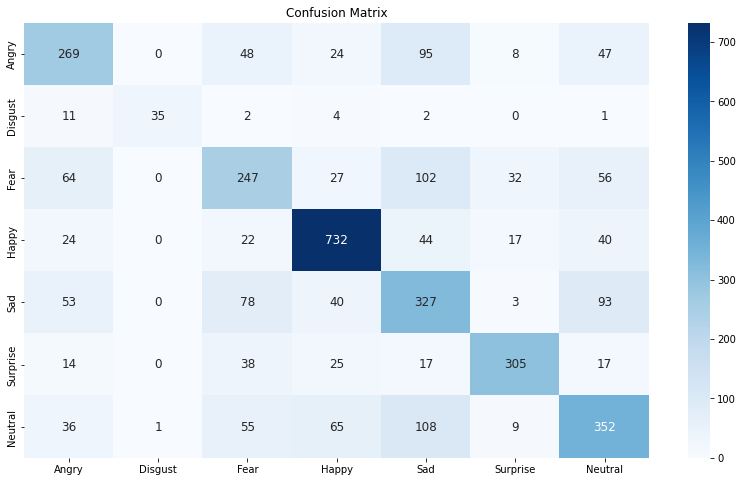

In [ ]:
emotion_dict = {0: "Angry", 1: "Disgust", 2: "Fear", 3: "Happy", 4: "Sad", 5: "Surprise", 6: 'Neutral'}

cm = confusion_matrix(y_test_, y_pred)
plt.figure(figsize = (14,8))
plt.title("Confusion Matrix")

ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", annot_kws={"size": 12}, xticklabels=['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'], yticklabels=['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'])

In [ ]:
print('Classification Report')

print(classification_report(y_test_, y_pred, target_names = emotion_dict.values()))

Classification Report
              precision    recall  f1-score   support

       Angry       0.57      0.55      0.56       491
     Disgust       0.97      0.64      0.77        55
        Fear       0.50      0.47      0.49       528
       Happy       0.80      0.83      0.82       879
         Sad       0.47      0.55      0.51       594
    Surprise       0.82      0.73      0.77       416
     Neutral       0.58      0.56      0.57       626

    accuracy                           0.63      3589
   macro avg       0.67      0.62      0.64      3589
weighted avg       0.64      0.63      0.63      3589



#### Stresli-Stressiz

In [ ]:
!unzip "/content/drive/MyDrive/VGGFace/vggface_ss.zip" -d "/content/model"

Archive:  /content/drive/MyDrive/VGGFace/vggface_ss.zip
  inflating: /content/model/vggface_ss.h5  


In [ ]:
son_model_2 = tf.keras.models.load_model("/content/model/vggface_ss.h5")

son_model_2.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_7 (Sequential)   (None, 1, 1, 512)         14714688  
                                                                 
 flatten_4 (Flatten)         (None, 512)               0         
                                                                 
 dense_8 (Dense)             (None, 256)               131328    
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 1)                 257       
                                                                 
Total params: 14,846,273
Trainable params: 131,585
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
y_test_2["emotion"].replace({"nan": 0}, inplace=True)
y_test_2

,id,emotion
0,0.jpg,0
1,1.jpg,1
2,2.jpg,1
3,3.jpg,0
4,4.jpg,0
...,...,...
3584,3584.jpg,1
3585,3585.jpg,1
3586,3586.jpg,0
3587,3587.jpg,1


In [ ]:
y_test__ = np.array(y_test_2["emotion"], dtype = "int")
y_test__

array([0, 1, 1, ..., 0, 1, 0])

In [ ]:
y_pred_2 = son_model_2.predict(test_gen_2)
label = [1 * (x[0]<=0.5) for x in y_pred_2] 

#label

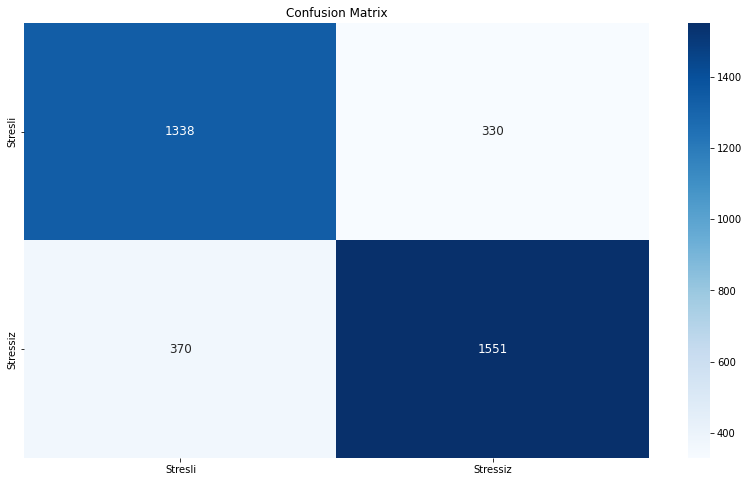

In [ ]:
emotion_dict = {0: "Stresli", 1: "Stressiz"}

cm = confusion_matrix(y_test__, label)
plt.figure(figsize = (14,8))
plt.title("Confusion Matrix")

ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", annot_kws={"size": 12}, xticklabels=['Stresli', 'Stressiz'], yticklabels=['Stresli', 'Stressiz'])

In [ ]:
print('Classification Report')

print(classification_report(y_test__, label, target_names = emotion_dict.values()))

Classification Report
              precision    recall  f1-score   support

     Stresli       0.78      0.80      0.79      1668
    Stressiz       0.82      0.81      0.82      1921

    accuracy                           0.80      3589
   macro avg       0.80      0.80      0.80      3589
weighted avg       0.81      0.80      0.81      3589

